<a href="https://colab.research.google.com/github/Waasem/AdversarialExamples/blob/main/RobustBench_json_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install RobustBench and preprocess the jsons from `model_info`

In [ ]:
!git clone https://github.com/RobustBench/robustbench

Cloning into 'robustbench'...
remote: Enumerating objects: 2331, done.
remote: Counting objects: 100% (770/770), done.
remote: Compressing objects: 100% (476/476), done.
remote: Total 2331 (delta 514), reused 480 (delta 284), pack-reused 1561
Receiving objects: 100% (2331/2331), 4.84 MiB | 18.84 MiB/s, done.
Resolving deltas: 100% (1534/1534), done.


In [ ]:
import os
import json
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
marker_size, line_width = 5.0, 0.75

dataset = 'cifar10'  # 'cifar10' or 'cifar100
threat_model = 'Linf'  # 'Linf' or 'L2'
json_file_names = os.listdir('robustbench/model_info/{}/{}'.format(dataset, threat_model))
if 'Standard.json' in json_file_names:
  json_file_names.remove('Standard.json')
standard_accs = np.zeros(len(json_file_names))
rob_accs_reported = np.zeros(len(json_file_names))
rob_accs_aa = np.zeros(len(json_file_names))
additional_data = np.zeros(len(json_file_names))
years = np.zeros(len(json_file_names))
venues = np.zeros(len(json_file_names), dtype='object')
for i, json_file_name in enumerate(json_file_names):
    with open('robustbench/model_info/{}/{}/{}'.
              format(dataset, threat_model, json_file_name), 'r') as model_info:
        json_dict = json.load(model_info)
        standard_accs[i] = float(json_dict['clean_acc'])
        rob_accs_reported[i] = float(json_dict['reported'])
        rob_accs_aa[i] = float(json_dict['autoattack_acc'])
        additional_data[i] = json_dict['additional_data']
        pos_year_beginning = json_file_name.find('20')
        years[i] = json_file_name[pos_year_beginning:pos_year_beginning+4]
        venues[i] = json_dict['venue']
additional_data = additional_data.astype('str')
additional_data[additional_data == '0.0'] = 'Models without extra data'
additional_data[additional_data == '1.0'] = 'Models with extra data'
venues[venues == ''] = 'Unpublished'

# set a consistent color palette; reverse it for L2 to keep the same palette
colors_extra_data = sns.color_palette()[:2]
# colors_extra_data = colors_extra_data[::-1] if threat_model == 'L2' else colors_extra_data

if not os.path.exists('images'):
  os.mkdir('images')

## Robust accuracy vs reported robust accuracy
As expected, we observe a sublinear trend, i.e. that the reported robust accuracy is often larger than the robust accuracy obtained via [AutoAttack](https://arxiv.org/abs/2003.01690)

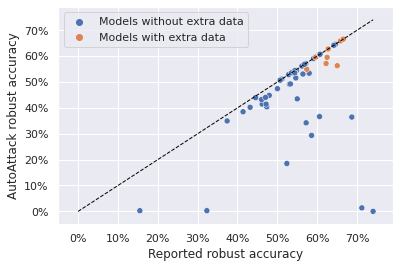

In [ ]:
# ax = sns.scatterplot(x=rob_accs_reported, y=rob_accs_aa, hue=additional_data)
ax = sns.scatterplot(x=rob_accs_reported, y=rob_accs_aa, hue=additional_data, palette=colors_extra_data)
plt.plot([min(rob_accs_aa), max(rob_accs_reported)], [min(rob_accs_aa), max(rob_accs_reported)], '--', linewidth=1, color='black')
ax.set_xlabel('Reported robust accuracy')
ax.set_ylabel('AutoAttack robust accuracy')
eps_axis_lim = 2 if threat_model == 'L2' or dataset == 'cifar100' else 5
ax.set_xlim(min(rob_accs_aa)-eps_axis_lim, max(rob_accs_reported)+eps_axis_lim)
ax.set_ylim(min(rob_accs_aa)-eps_axis_lim, max(rob_accs_reported)+eps_axis_lim)
ax.set_xticklabels(['{:.0%}'.format(v/100) for v in ax.get_xticks()])
ax.set_yticklabels(['{:.0%}'.format(v/100) for v in ax.get_yticks()])
ax.legend(loc='upper left')

plt.savefig('images/aa_robustness_vs_reported_{}.pdf'.format(threat_model), bbox_inches='tight', pad_inches=0.0)
plt.savefig('images/aa_robustness_vs_reported_{}.png'.format(threat_model), bbox_inches='tight', pad_inches=0.0, dpi=200)

## Robust accuracy vs standard accuracy
Nice visualization of the accuracy-robustness tradeoff, extra data seems to be a game changer.

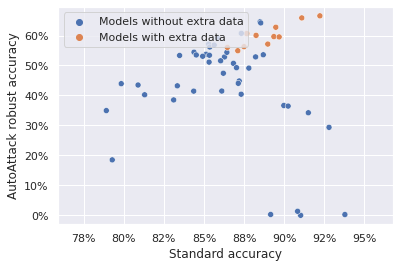

In [ ]:
ax = sns.scatterplot(x=standard_accs, y=rob_accs_aa, hue=additional_data, palette=colors_extra_data)
ax.set_xlabel('Standard accuracy')
ax.set_ylabel('AutoAttack robust accuracy')
eps_axis_lim_x = 0.75 if threat_model == 'L2' else 3
eps_axis_lim_y = 2 if threat_model == 'L2' else 3
ax.set_xlim(min(standard_accs)-eps_axis_lim_x, max(standard_accs)+eps_axis_lim_x)
ax.set_ylim(min(rob_accs_aa)-eps_axis_lim_y, max(rob_accs_aa)+eps_axis_lim_y)
ax.set_xticklabels(['{:.0%}'.format(v/100) for v in ax.get_xticks()])
ax.set_yticklabels(['{:.0%}'.format(v/100) for v in ax.get_yticks()])
ax.legend(loc='upper left')

plt.savefig('images/aa_robustness_vs_standard_{}.pdf'.format(threat_model), bbox_inches='tight', pad_inches=0.0)
plt.savefig('images/aa_robustness_vs_standard_{}.png'.format(threat_model), bbox_inches='tight', pad_inches=0.0, dpi=200)

## Robust accuracy vs years 
Such a breakdown is probably not too informative since most of the models are from 2019 and 2020 only.

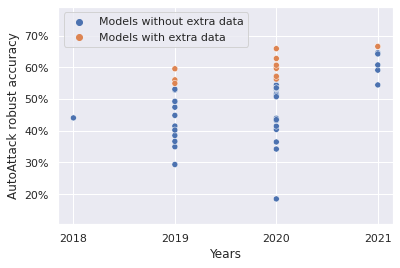

In [ ]:
years = [int(year) for year in years]
ax = sns.scatterplot(x=years, y=rob_accs_aa, hue=additional_data, palette=colors_extra_data)
ax.set_xlabel('Years')
ax.set_ylabel('AutoAttack robust accuracy')
eps_axis_lim = 2 if threat_model == 'L2' else 5
xticks = np.unique(years) if 2018 in years else np.append([2018], np.unique(years))  # append 2018 to prevent some plotting problems with the X axis
ax.set_xticks(xticks)
ax.set_ylim(min(rob_accs_reported)-eps_axis_lim, max(rob_accs_reported)+eps_axis_lim)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(decimals=0))
ax.legend(loc='upper left')

plt.savefig('images/aa_robustness_vs_years_{}.pdf'.format(threat_model), bbox_inches='tight', pad_inches=0.0)
plt.savefig('images/aa_robustness_vs_years_{}.png'.format(threat_model), bbox_inches='tight', pad_inches=0.0, dpi=200)

## Robust accuracy vs venues
NeurIPS 2019 was great, ICLR 2020 not much, Unpublished papers are more robust on average than ICLR 2020 papers

['NeurIPS 2020' 'ICCV 2019' 'CVPR 2019' 'NeurIPS 2019' 'NeurIPS 2019'
 'NeurIPS 2020' 'Unpublished' 'ICML 2019' 'Unpublished' 'CVPR 2020'
 'Unpublished' 'NeurIPS 2019' 'NeurIPS 2020' 'Unpublished' 'Unpublished'
 'Unpublished' 'Unpublished' 'IJCAI 2019' 'Unpublished' 'ICLR 2020'
 'ICCV 2019' 'NeurIPS 2020' 'NeurIPS 2019' 'Unpublished' 'ICLR 2020'
 'ICLR 2020' 'Unpublished' 'NeurIPS 2019' 'Unpublished' 'ICCV 2019'
 'ICLR 2020' 'ICLR 2021' 'ICLR 2021' 'Unpublished' 'ICML 2020' 'ICML 2020'
 'Unpublished' 'NeurIPS 2019' 'ICLR 2018' 'NeurIPS 2020' 'Unpublished'
 'Unpublished' 'ICLR 2020' 'Unpublished' 'ICML 2019' 'Unpublished'
 'Unpublished' 'Unpublished' 'ICLR 2020' 'NeurIPS 2019' 'Unpublished'
 'NeurIPS 2020' 'NeurIPS 2019' 'Unpublished']
(54,) (54,)


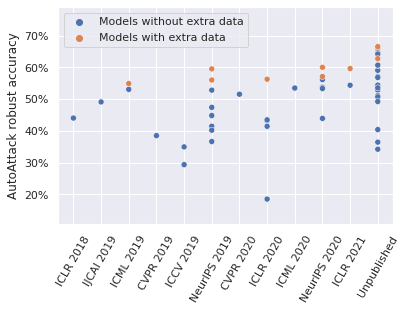

In [ ]:
conference_list = np.array(['ICLR 2018', 'IJCAI 2019', 'ICML 2019', 'CVPR 2019', 'ICCV 2019', 'NeurIPS 2019', 'CVPR 2020', 
                            'ICLR 2020', 'ICML 2020', 'ECCV 2020', 'NeurIPS 2020', 'ICLR 2021', 'Unpublished'])
venues_cleaned = np.array([venue if venue in conference_list else 'Unpublished' for venue in venues])
conference_list = np.array([conf for conf in conference_list if conf in venues_cleaned])  # keep only the conferences which are present for the current threat model
print(venues_cleaned)


ind = np.where(venues_cleaned.reshape(venues_cleaned.size, 1) == conference_list)[1]
print(ind.shape, rob_accs_aa.shape)

ax = sns.scatterplot(x=ind, y=rob_accs_aa, hue=additional_data, palette=colors_extra_data)
ax.set_ylabel('AutoAttack robust accuracy')
eps_axis_lim = 2 if threat_model == 'L2' else 5
ax.set_xticks(range(len(conference_list)))
ax.set_xticklabels(conference_list)
plt.xticks(rotation=60)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(decimals=0))
ax.set_ylim(min(rob_accs_reported)-eps_axis_lim, max(rob_accs_reported)+eps_axis_lim)
ax.legend(loc='upper left')

plt.savefig('images/aa_robustness_vs_venues_{}.pdf'.format(threat_model), bbox_inches='tight', pad_inches=0.0)
plt.savefig('images/aa_robustness_vs_venues_{}.png'.format(threat_model), bbox_inches='tight', pad_inches=0.0, dpi=200)

## Robustness overestimation vs venues

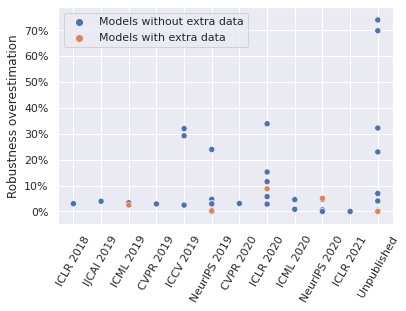

In [ ]:
rob_overestimation = rob_accs_reported-rob_accs_aa
ax = sns.scatterplot(x=ind, y=rob_overestimation, hue=additional_data, palette=colors_extra_data)
ax.set_ylabel('Robustness overestimation')
eps_axis_lim = 0.5 if threat_model == 'L2' else 5
ax.set_xticks(range(len(conference_list)))
ax.set_xticklabels(conference_list)
plt.xticks(rotation=60)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(decimals=0))
ax.set_ylim(min(rob_overestimation)-eps_axis_lim, max(rob_overestimation)+eps_axis_lim)
ax.legend(loc='upper left')

plt.savefig('images/aa_robustness_overestimation_vs_venues_{}.pdf'.format(threat_model), bbox_inches='tight', pad_inches=0.0)
plt.savefig('images/aa_robustness_overestimation_vs_venues_{}.png'.format(threat_model), bbox_inches='tight', pad_inches=0.0, dpi=200)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

if not os.path.exists('/content/drive/My Drive/plots_{}/'.format(dataset)):
  os.mkdir('/content/drive/My Drive/plots_{}/'.format(dataset))

for img_fname in os.listdir('images'):
  source_path = 'images/' + img_fname
  destination_path = '/content/drive/My\ Drive/plots_{}/{}'.format(dataset, img_fname)
  os.system('cp {} {}'.format(source_path, destination_path)) 
  print('Copied: {}'.format(img_fname))

Mounted at /content/drive
Copied: aa_robustness_vs_venues_Linf.png
Copied: aa_robustness_vs_years_Linf.png
Copied: aa_robustness_vs_standard_Linf.pdf
Copied: aa_robustness_overestimation_vs_venues_Linf.pdf
Copied: aa_robustness_vs_standard_Linf.png
Copied: aa_robustness_vs_reported_Linf.pdf
Copied: aa_robustness_vs_venues_Linf.pdf
Copied: aa_robustness_overestimation_vs_venues_Linf.png
Copied: aa_robustness_vs_years_Linf.pdf
Copied: aa_robustness_vs_reported_Linf.png
